<i><b>Public AI</b></i>
<br>
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 1. Numpy Basis**
# Section 8. Numpy을 활용하여 머신러닝 구현하기 - K-Means 군집화

### _Objective_
1. **K-Means 알고리즘 개괄** : 대표적인 군집화 방법론 중 하나인 K-Means 알고리즘을 이해합니다.<br>
2. **K-Means 알고리즘 구현** : K-Means 알고리즘을 Numpy로 구현해봅니다. <br>

In [1]:
%matplotlib inline
import numpy as np
import os

import matplotlib.pyplot as plt

# \[ 1. K-Means 알고리즘 개괄 \]

K-Means 알고리즘은 주어진 데이터를 K개의 클러스터로 묶는 '군집화 알고리즘' 중 하나로, 각 클러스터의 중심과 각 데이터 간의 거리 차이의 분산을 최소화하는 방식으로 데이터가 속할 군집을 묶어나갑니다.

우선 예제 데이터를 준비합시다. 

In [2]:
# 예제 데이터셋 준비하기
if not os.path.exists("./kmeans_dataset.txt"):
    !wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/kmeans_dataset.txt
dataset = np.loadtxt("./kmeans_dataset.txt")

예제 데이터를 시각화해봅시다. 

In [3]:
dataset

array([[ 1.658985,  4.285136],
       [-3.453687,  3.424321],
       [ 4.838138, -1.151539],
       [-5.379713, -3.362104],
       [ 0.972564,  2.924086],
       [-3.567919,  1.531611],
       [ 0.450614, -3.302219],
       [-3.487105, -1.724432],
       [ 2.668759,  1.594842],
       [-3.156485,  3.191137],
       [ 3.165506, -3.999838],
       [-2.786837, -3.099354],
       [ 4.208187,  2.984927],
       [-2.123337,  2.943366],
       [ 0.704199, -0.479481],
       [-0.39237 , -3.963704],
       [ 2.831667,  1.574018],
       [-0.790153,  3.343144],
       [ 2.943496, -3.357075],
       [-3.195883, -2.283926],
       [ 2.336445,  2.875106],
       [-1.786345,  2.554248],
       [ 2.190101, -1.90602 ],
       [-3.403367, -2.778288],
       [ 1.778124,  3.880832],
       [-1.688346,  2.230267],
       [ 2.592976, -2.054368],
       [-4.007257, -3.207066],
       [ 2.257734,  3.387564],
       [-2.679011,  0.785119],
       [ 0.939512, -4.023563],
       [-3.674424, -2.261084],
       [

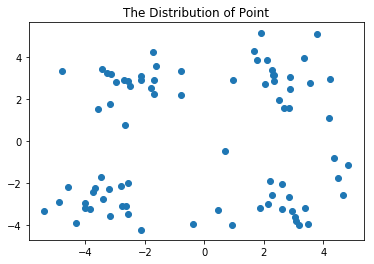

In [4]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1])
plt.show()

위 산점도를 보면, 예제 데이터에는 크게 4개의 군집이 있음을 직관적으로 파악할 수 있습니다. 각 군집의 대략적인 중심을 잡아보면 아래와 같을 것입니다. 

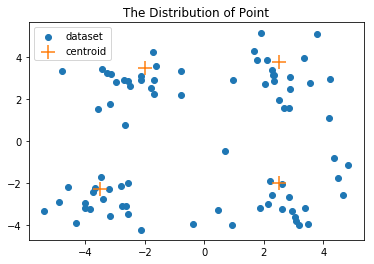

In [5]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1],label='dataset')
plt.scatter([-3.5,-2,2.5,2.5],[-2.3,3.5,3.8,-2],
            s=200, label="centroid", marker='+')
plt.legend()
plt.show()

<div class="alert alert-success" role="alert">
  여기서 군집이 안정화 되었다는 말은 샘플들의 군집 소속이 더이상 바뀌지 않았을 때를 말합니다.
</div>

위와 같이 군집을 묶어 주기 위해서는 4개의 중심을 잘 잡을 필요가 있습니다. K-Means 군집화 알고리즘에서는 **중심점과 데이터 간의 거리**를 구하고, 그 거리가 가장 작아지는 중심점을 찾도록, 중심점을 반복적으로 옮겨가는 과정을 반복합니다. 현재 군집에 속한 실제 요소를 고려해 중심점을 반복적으로 계산하다가 중심이 안정화되면 알고리즘을 중단합니다.

---

# \[ 2. Numpy로  K-Means 구현하기 \]

K-means의 알고리즘의 순서는 다음과 같습니다: 

1. 초기 중심점을 설정하기 위해 K개의 점 임의 생성
2. K개의 중심점과 각 데이터 사이의 거리 계산
3. 각 데이터를 거리가 가장 가까운 군집으로 할당
4. 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
5. 2~4의 과정을 통해 각 데이터 별 군집이 바뀌지 않았으면, 이 과정을 끝냄

각 단계를 Numpy로 구현하는 코드를 작성해본 후, 전체 코드를 합쳐보겠습니다. 

## 1. 각 단계별로 Numpy Code 작성하기

### (1) 초기 중심점을 설정하기 위해 K개의 점 임의 생성

예제 데이터는 두 개의 축으로 표현할 수 있는 데이터입니다. K-means 알고리즘은 데이터 공간에서 임의의 점 K개(여기선 4개)를 랜덤하게 산출하는 데서 시작됩니다. 임의로 산출한다고 하지만, 임의의 중심점 4개는 데이터 셋 부근에 있어야 합니다. 따라서 데이터셋의 범위를 파악하고 그 안에서 임의의 값을 뽑아 점 4개를 생성해보겠습니다.

Numpy의 `np.random`을 이용하면 데이터의 최소 최대값 범위 안에서 지정한 확률 분포에 따라 임의의 값을 추출할 수 있습니다. 예를 들어 위 데이터셋에서 x축 데이터의 범위 안의 수를 동일한 확률로 뽑고 싶다면, 확률 분포를 연속균등분포(`uniform`)으로 설정하고 샘플링을 하면 됩니다. 

In [6]:
# fix me! # x축의 최소값
# fix me! # x축의 최대값
# fix me! # 연속 균등 분포로 임의의 x축 값 추출하기 

0.38417403656085725

위와 같은 방법으로 x축과 y축 각각 범위 내 랜덤한 값 K개를 산출한다면, <br>
> 원활한 시각화를 위해 중심 좌표들의 변수명은 **centroids**로 설정해주세요!

In [7]:
# fix me! # K점의 수 설정

# x축과 y축의 최소 최대값을 추출
# fix me!

# k개의 랜덤 x값과 랜덤 y값을 추출하여 짝을 만든 후, centroids 리스트에 추가
# fix me! # with python for 구문

위의 코드를 좀 더 numpy답게 작성하면 아래처럼 작성할 수 있습니다.

In [8]:
# fix me! # Numpy를 사용해 코드 작성하기

위와 같이 랜덤으로 산출한 중심점은 아래와 같이 산재해 있습니다.

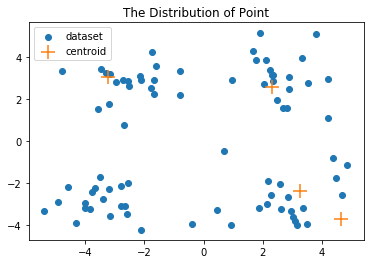

In [9]:
# 예제 데이터셋 시각화
plt.title("The Distribution of Point")
plt.scatter(dataset[:,0],dataset[:,1],label='dataset')
plt.scatter(centroids[:,0],centroids[:,1],
            s=200, label="centroid", marker='+')
plt.legend()
plt.show()

### (2) 중심점과 각 데이터 사이의 거리를 계산

거리 공식은 KNN 때와 마찬가지로, 아래와 같습니다. 우리는 모든 중심점과 각 데이터 간 거리를 구해야 합니다.

$$
point1 = (x_1,y_1), point2 = (x_2,y_2)\mbox{일 때}\\
distance\_between\_point1\_and\_point2 = \sqrt{(x_1-x_2)^2 + (y_1-y_2)^2}
$$

In [10]:
# 각 중심점을 기준으로 각 데이터 간 거리 계산하기
# fix me! # with python for 구문

array([[ 6.84659299,  8.85966923,  2.0100346 ,  8.67970639,  5.76577015,
         7.85266918,  2.94284286,  6.76226368,  4.01178337,  8.48237012,
         1.62619761,  6.07386234,  5.44652038,  7.55619695,  3.16926666,
         3.96782333,  3.97098002,  6.99824684,  1.02644567,  6.44027557,
         5.32844211,  7.04304002,  1.15351247,  6.65929923,  6.42573081,
         6.74824339,  0.72569696,  7.29852296,  5.84682704,  6.71331911,
         2.8329325 ,  6.91911162,  5.24921562,  7.65877381,  1.92017983,
         5.93017679,  7.6862493 ,  6.09470653,  0.49591988,  7.13587499,
         6.36572572,  7.96989853,  0.81860411,  5.67752313,  5.63000629,
         8.63301764,  1.4477446 ,  7.00606334,  5.16298085,  8.28160212,
         1.27153539,  7.72720178,  7.53128268,  9.86731487,  1.08052899,
         7.27802914,  4.40360883,  7.63707053,  1.59496351,  6.52563429,
         4.87719163,  7.83454422,  1.59130295,  5.82082554,  6.35925112,
         7.6819318 ,  0.98052985,  5.93971241,  5.6

In [11]:
# fix me! # 결과 행렬의 shape은?

(4, 80)

In [12]:
# fix me! # 1번째 중심점과 32번째 데이터 간 거리

6.948245932288003

* Numpy Code의 reshape와 broadcasting을 활용하면 간결하게 나타낼 수 있습니다.

In [13]:
# fix me! # Numpy의 reshape과 broadcasting을 활용하기

(4, 80)

### (3) 각 데이터를 거리가 가장 가까운 군집으로 할당

각 데이터를 거리가 가장 가까운 군집으로 할당 하기 위해서는, `argmin`을 통해 간단히 구할 수 있습니다.

In [14]:
# fix me! # 각 데이터를 가장 가까운 군집으로 할당하기

array([3, 2, 0, 2, 3, 2, 0, 2, 3, 2, 1, 0, 3, 2, 0, 0, 3, 2, 0, 2, 3, 2,
       0, 2, 3, 2, 0, 2, 3, 2, 0, 2, 3, 2, 0, 0, 3, 2, 0, 2, 3, 2, 0, 0,
       3, 2, 0, 2, 3, 2, 0, 2, 3, 2, 0, 2, 3, 2, 0, 0, 3, 2, 1, 2, 3, 2,
       0, 0, 3, 2, 0, 2, 3, 2, 1, 2, 3, 2, 0, 2])

각 점에서 가장 가까운 중심점의 index를 위와 같은 방식으로 산출할 수 있습니다.

### (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산

In [15]:
# for 구문을 사용해 k개의 군집을 순회하며 각 군집의 평균을 군집의 중심점으로 다시 할당하기
# fix me! 

### (5) 2~4의 과정을 통해 각 데이터 별 군집이 바뀌지 않았으면, 이 과정을 끝냄

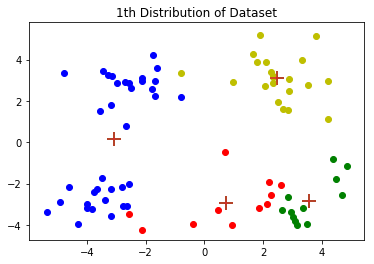

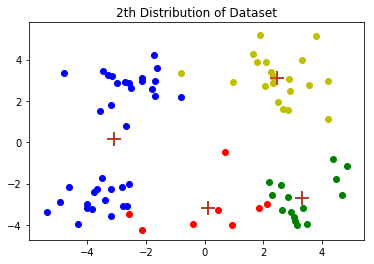

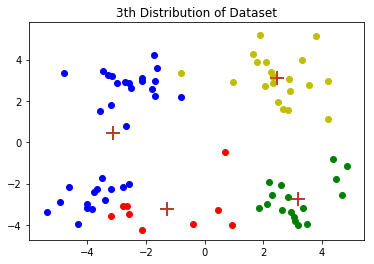

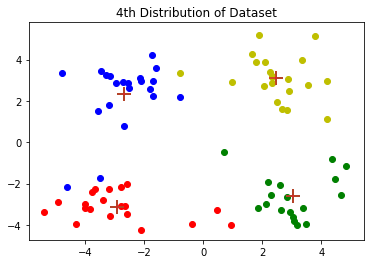

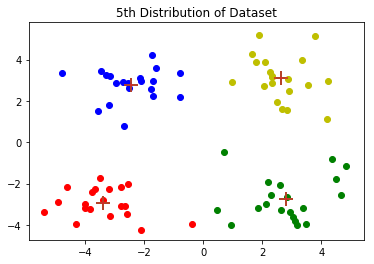

In [16]:
num_data = dataset.shape[0]

cluster_per_point = np.ones((num_data))

counter = 0
while True:
    prev_cluster_per_point = cluster_per_point
    
    diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
    dists = np.sqrt((diff_mat**2).sum(axis=-1))
    cluster_per_point = dists.argmin(axis=0)

    for i in range(k):
        centroids[i] = dataset[cluster_per_point==i].mean(axis=0)
        
    if np.all(prev_cluster_per_point == cluster_per_point):
        break
        
    counter += 1
    plt.title("{}th Distribution of Dataset".format(counter))
    for idx, color in enumerate(['r','g','b','y']):
        mask = (cluster_per_point==idx)
        plt.scatter(dataset[mask,0],dataset[mask,1],
                    label='dataset', c=color)
        plt.scatter(centroids[:,0],centroids[:,1],
                    s=200, label="centroid", marker='+')
    plt.show()

## 2. 전체 Numpy Code 작성하기

In [17]:
def cluster_kmeans(dataset, k):    
    # (1) 중심점 초기화
    min_x = dataset[:,0].min()
    max_x = dataset[:,0].max() 
    min_y = dataset[:,1].min()
    max_y = dataset[:,1].max() 

    center_x = np.random.uniform(low=min_x, high=max_x, size=k)
    center_y = np.random.uniform(low=min_y, high=max_y, size=k)
    centroids = np.stack([center_x,center_y],axis=-1)
    
    # (2) ~ (5) 순회
    num_data = dataset.shape[0]
    cluster_per_point = np.zeros((num_data)) # 각 점 별 군집

    counter = 0
    while True:
        prev_cluster_per_point = cluster_per_point
        
        # (2) 거리 계산
        diff_mat = (centroids.reshape(-1,1,2) - dataset.reshape(1,-1,2))
        dists = np.sqrt((diff_mat**2).sum(axis=-1))
        # (3) 각 데이터를 거리가 가장 가까운 군집으로 할당
        cluster_per_point = dists.argmin(axis=0)
        
        # (4) 각 군집 별 점들의 평균을 계산 후, 군집의 중심점을 다시 계산
        for i in range(k):
            centroids[i] = dataset[cluster_per_point==i].mean(axis=0)

        if np.all(prev_cluster_per_point == cluster_per_point):
            break

        counter += 1
        plt.title("{}th Distribution of Dataset".format(counter))
        for idx, color in enumerate(['r','g','b','y']):
            mask = (cluster_per_point==idx)
            plt.scatter(dataset[mask,0],dataset[mask,1],
                        label='dataset', c=color)
            plt.scatter(centroids[:,0],centroids[:,1],
                        s=200, label="centroid", marker='+')
        plt.show()
    
    return centroids

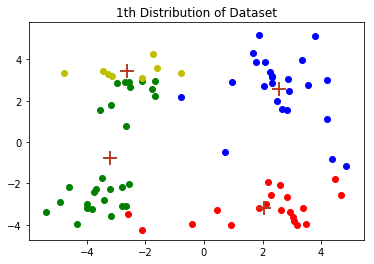

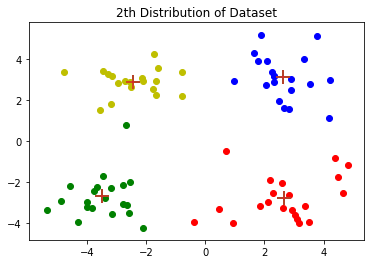

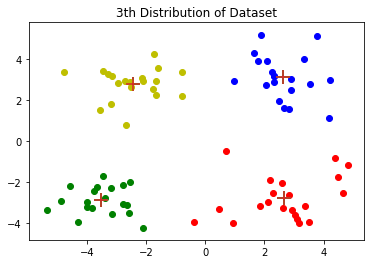

array([[ 2.65077367, -2.79019029],
       [-3.53973889, -2.89384326],
       [ 2.6265299 ,  3.10868015],
       [-2.46154315,  2.78737555]])

In [18]:
cluster_kmeans(dataset,4)

<div class="alert alert-success" role="alert">
  1. "군집은 각 데이터 포인트가 레이블을 가진다는 면에서 classification 문제와 조금 비슷해 보입니다. 그러나 정답을 모르고 있으며 레이블 자체에 어떤 의미가 있지는 않습니다." 로 마무리 <br>
  2. sklearn을 사용해 원형이 아닌 클러스터를 구분하지 못하는것, 복잡한 모양의 클러스터를 구분하지 못하는 것을 보여주기
</div>

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/04

---